## **Plant height measure**

In [18]:
import cv2
import numpy as np

def measure_plant_height(image_path, reference_height_cm):
    # Load the image
    image = cv2.imread(image_path)
    original_image = image.copy()

    reference_height_pixels = image.shape[0]
    
    # Convert to HSV color space for better color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define lower and upper bounds for green (common color of plants)
    lower_green = np.array([30, 50, 50])
    upper_green = np.array([90, 255, 255])

    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Find contours in the masked image
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize variables to store the plant contour
    plant_contour = None
    max_height = 0
    bounding_box = None
    
    # Loop through contours to find the plant
    for contour in contours:
        # Get the bounding box for each contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filter based on height and width to find the plant
        if h > max_height and w > 10:  # Ensure width is reasonable
            max_height = h
            plant_contour = contour
            bounding_box = (x, y, w, h)
    
    if plant_contour is not None:
        # Calculate the height of the plant in cm
        plant_height_pixels = max_height
        plant_height_cm = (plant_height_pixels / reference_height_pixels) * reference_height_cm
        
        # Draw the bounding box around the plant
        x, y, w, h = bounding_box
        cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 255, 0), 10)
        
        # Draw the height on the image
        cv2.putText(original_image, f'Height: {plant_height_cm:.2f} cm', (10, 150), 
                    cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 10)
        
        # Show the result
        cv2.imshow('Plant Height Measurement', original_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
        return plant_height_cm
    else:
        print("No plant contour found.")
        return None

# Example usage
image_path = 'images/Leaf count/filtered/filtered_image.jpg'
reference_height_cm = 25  # Height of the reference object in cm

plant_height = measure_plant_height(image_path, reference_height_cm)
if plant_height is not None:
    print(f'Measured Plant Height: {plant_height:.2f} cm')

Measured Plant Height: 2.41 cm


## **This is ok with draw a square around the plant**

In [17]:
import cv2
import numpy as np

def measure_plant_height(image_path, reference_height_cm):
    # Load the image
    image = cv2.imread(image_path)
    original_image = image.copy()

    reference_height_pixels = image.shape[0]
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    # Morphological operations to close gaps in edges
    kernel = np.ones((5, 5), np.uint8)
    dilated = cv2.dilate(edges, kernel, iterations=1)
    
    # Find contours
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize variables to store the plant contour
    plant_contour = None
    max_height = 0
    bounding_box = None
    
    # Loop through contours to find the plant
    for contour in contours:
        # Get the bounding box for each contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filter based on height and width to find the plant
        if h > max_height and w > 10:  # Ensure width is reasonable
            max_height = h
            plant_contour = contour
            bounding_box = (x, y, w, h)
    
    if plant_contour is not None:
        # Calculate the height of the plant in pixels
        plant_height_pixels = max_height
        
        # Calculate the conversion factor from pixels to cm
        conversion_factor = reference_height_cm / reference_height_pixels
        
        # Calculate the height of the plant in cm
        plant_height_cm = plant_height_pixels * conversion_factor
        
        # Draw the bounding box around the plant
        x, y, w, h = bounding_box
        cv2.rectangle(original_image, (x, y), (x + w, y + h), (0, 255, 0), 12)
        
        # Draw the height on the image
        cv2.putText(original_image, f'Height: {plant_height_cm:.2f} cm', (10, 150), 
                    cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 10)
        
        # Show the result
        cv2.imshow('Plant Height Measurement', original_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
        return plant_height_cm
    else:
        print("No plant contour found.")
        return None

# Example usage
image_path = 'images/Leaf count/filtered/filtered_image.jpg'
reference_height_cm = 25  # Height of the reference object in cm

plant_height = measure_plant_height(image_path, reference_height_cm)
if plant_height is not None:
    print(f'Measured Plant Height: {plant_height:.2f} cm')

Measured Plant Height: 18.43 cm


## **Correct one to calculate height of the plant**

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from pillow_heif import register_heif_opener

register_heif_opener()

def measure_plant_height(image_path, reference_height_cm):
    image = cv2.imread(image_path)
    original_image = image.copy()

    reference_height_pixels = image.shape[0]
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    edges = cv2.Canny(blurred, 50, 150)
    
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    plant_contour = None
    max_height = 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        if h > max_height:
            max_height = h
            plant_contour = contour
    
    if plant_contour is not None:
        plant_height_pixels = max_height
        plant_height_cm = (plant_height_pixels / reference_height_pixels) * reference_height_cm
        
        cv2.drawContours(original_image, [plant_contour], -1, (0, 255, 0), 12)
        cv2.putText(original_image, f'Height: {plant_height_cm:.2f} cm', (10, 150), 
                    cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 5)
        
        # cv2.imshow('Plant Height Measurement', original_image)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        
        return plant_height_cm
    else:
        print("No plant contour found.")
        return None

# image_path = 'images/Leaf count/'
reference_height_cm = 25  # Height of the reference object in cm

# plant_height = measure_plant_height(image_path, reference_height_cm)
# if plant_height is not None:
#     print(f'Measured Plant Height: {plant_height:.2f} cm')

Measured Plant Height: 2.42 cm
Measured Plant Height: 5.86 cm
Measured Plant Height: 13.72 cm
Measured Plant Height: 15.68 cm
Measured Plant Height: 7.37 cm
Measured Plant Height: 6.40 cm
Measured Plant Height: 22.45 cm
Measured Plant Height: 17.73 cm
Measured Plant Height: 21.45 cm
Measured Plant Height: 2.41 cm


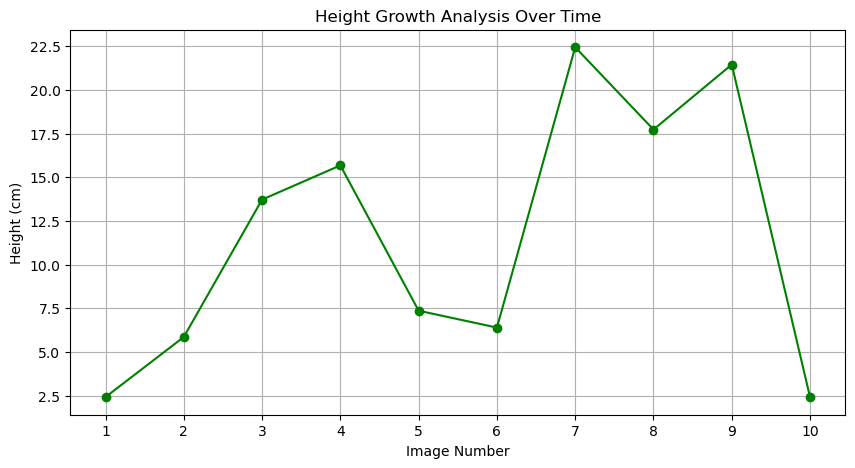

In [22]:
image_paths = []
input_path = Path('images/Leaf count')
for image_file in input_path.rglob('*.jpg'):
        image_paths.append(image_file)

# Collect leaf count data
height_counts = []

for image_path in image_paths:
    plant_height = measure_plant_height(image_path, reference_height_cm)
    if plant_height is not None:
        height_counts.append(plant_height)
        print(f'Measured Plant Height: {plant_height:.2f} cm')

# Plotting leaf count growth over time
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(height_counts) + 1), height_counts, marker='o', linestyle='-', color='g')
plt.title('Height Growth Analysis Over Time')
plt.xlabel('Image Number')
plt.ylabel('Height (cm)')
plt.xticks(range(1, len(height_counts) + 1))
plt.grid()
plt.show()